# Gas CART

## Import and load

In [2]:
import sys
sys.path.insert(1, '../') 
from utils.loader import Loader
from utils.data_processor import Data_processor
from utils.cluster_generator import ClusterGenerator
from utils.master_generator import MasterGenerator

import pandas as pd
from sklearn import tree
import os
import seaborn as sns
import matplotlib.pyplot as plt
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import LabelEncoder, StandardScaler, OneHotEncoder
from sklearn.tree import DecisionTreeClassifier, plot_tree
from sklearn.metrics import accuracy_score, classification_report, confusion_matrix
from sklearn.preprocessing import LabelEncoder, StandardScaler
from sklearn.tree import DecisionTreeClassifier, plot_tree
from sklearn.decomposition import PCA,TruncatedSVD
from sklearn.linear_model import LinearRegression
from sklearn.impute import SimpleImputer
from sklearn.metrics import mean_absolute_error
from sklearn.tree import DecisionTreeRegressor
from sklearn.feature_selection import chi2
import matplotlib.pyplot as plt
from mpl_toolkits.mplot3d import Axes3D
from utils.evaluator import Evaluator
import prince
import numpy as np
from sklearn.svm import SVC, SVR
import pandas as pd
from imblearn.over_sampling import SMOTE
from sklearn.naive_bayes import GaussianNB
from sklearn.model_selection import train_test_split
from sklearn.tree import DecisionTreeClassifier
from sklearn.ensemble import RandomForestClassifier, RandomForestRegressor
from sklearn.metrics import classification_report, confusion_matrix
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Dense


c:\Users\marti\Desktop\asignaturas\machineLearning\Cars_Price_Prediction\.venv\Lib\site-packages\tqdm\auto.py:21: TqdmWarning: IProgress not found. Please update jupyter and ipywidgets. See https://ipywidgets.readthedocs.io/en/stable/user_install.html
  from .autonotebook import tqdm as notebook_tqdm


### Load GAS type cars

In [3]:
data = Loader.load_by_fueltype("Gas")
label_encoder = LabelEncoder()

c:\Users\marti\Desktop\asignaturas\machineLearning\Cars_Price_Prediction\Trees\..\utils\loader.py:153: DtypeWarning: Columns (120) have mixed types. Specify dtype option on import or set low_memory=False.
  df = pd.read_csv(file_path,
c:\Users\marti\Desktop\asignaturas\machineLearning\Cars_Price_Prediction\Trees\..\utils\loader.py:153: DtypeWarning: Columns (120) have mixed types. Specify dtype option on import or set low_memory=False.
  df = pd.read_csv(file_path,
c:\Users\marti\Desktop\asignaturas\machineLearning\Cars_Price_Prediction\Trees\..\utils\loader.py:165: FutureWarning: A value is trying to be set on a copy of a DataFrame or Series through chained assignment using an inplace method.
The behavior will change in pandas 3.0. This inplace method will never work because the intermediate object on which we are setting values always behaves as a copy.

For example, when doing 'df[col].method(value, inplace=True)', try using 'df.method({col: value}, inplace=True)' or df[col] = df[co

In [4]:
data["price_categ"].value_counts()

price_categ
Middle low range     509
Budget               480
Low end              250
Middle range          31
Middle high range     16
Very low end           3
High end               1
Luxury                 0
Premiun                0
Name: count, dtype: int64

In [5]:
data['price_categ'] = data['price_categ'].replace({ # Combinar clases similares
    'Luxury': 'Alto',
    'Premiun': 'Alto',
    'High end': 'Alto',
    'Middle high range': 'Alto',
})

data = data[data['price_categ'] != 'Very low end'] # Eliminar la clase 'Very low end'
data['price_categ'] = data['price_categ'].str.strip()

# Revisa la nueva distribución
data['price_categ'].value_counts()

C:\Users\marti\AppData\Local\Temp\ipykernel_11048\787252135.py:1: FutureWarning: The behavior of Series.replace (and DataFrame.replace) with CategoricalDtype is deprecated. In a future version, replace will only be used for cases that preserve the categories. To change the categories, use ser.cat.rename_categories instead.
  data['price_categ'] = data['price_categ'].replace({ # Combinar clases similares


price_categ
Middle low range    509
Budget              480
Low end             250
Middle range         31
Alto                 17
Name: count, dtype: int64

In [6]:
# Ajustar y transformar la columna price_categ
data['price_categ'] = data["price_categ"].apply(Loader.encode_price_categ).to_numpy()
data['price_categ'].value_counts()

price_categ
3    509
2    480
1    250
4     31
8     17
Name: count, dtype: int64

#### We can see the data is hightly unbalance and needs treatment before reating the tree model 

Aproach 1

**SMOTE**

This method addresses data imbalance by generating synthetic samples for the minority class.





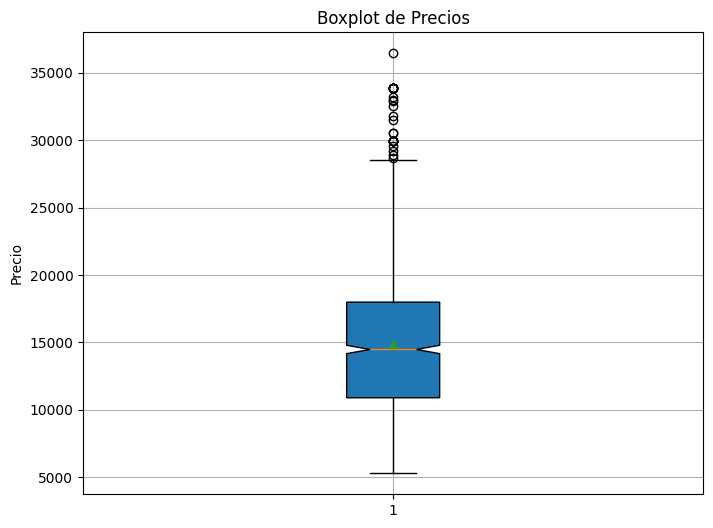

In [7]:
precios_gas = data["price"]
plt.figure(figsize=(8, 6))
plt.boxplot(precios_gas, notch=True, vert=True, patch_artist=True, showmeans=True)
plt.title('Boxplot de Precios')
plt.ylabel('Precio')
plt.grid(True)
plt.show()

The outliers were checked manually throught the data source, and we could confirmed that they are not outliers

In [8]:
Q1 = data['price'].quantile(0.25)
Q2 = data['price'].quantile(0.5)  # Esta es la mediana
Q3 = data['price'].quantile(0.75)
IQR = Q3 - Q1

upper_whisker = (Q3 + 1.5 * IQR)
print(upper_whisker)

data[data["price"]>upper_whisker][["price", "brand"]].sort_values(by='price', ascending=False)

28625.0


,price,brand
idx,,
48483,36441,DFSK
37736,33900,EVO
24917,33900,EVO
40872,33900,EVO
43137,33900,EVO
85825,33900,EVO
91054,33900,EVO
43076,33900,EVO
34644,33899,PIAGGIO


### Gas , Numerical variables selection

In [9]:
def fill_gas_numerical_columns(numerical_columns: pd.DataFrame) -> pd.DataFrame:
    #fill the elemental columns that has a minor amount of missing data with the mode
    numerical_columns = Data_processor.fill_na_with_mode(numerical_columns, "dimensions.length")
    numerical_columns = Data_processor.fill_na_with_mode(numerical_columns, "dimensions.height")

    #fill the missing data witch regression, the parameters were based on the relation matrix 
    numerical_columns = Data_processor.impute_with_linear_regression(data=numerical_columns, x_columns=["dimensions.length", "dimensions.height"], y_column="dimensions.width")
    numerical_columns = Data_processor.impute_with_linear_regression(data=numerical_columns, x_columns=["dimensions.length", "dimensions.height", "dimensions.width"], y_column="trunkCapacityInLiters")
    numerical_columns = Data_processor.impute_with_linear_regression(data=numerical_columns, x_columns=["power_cv", "power_kw"], y_column="maxSpeed")
    numerical_columns = Data_processor.impute_with_linear_regression(data=numerical_columns, x_columns=["power_cv", "power_kw", "maxSpeed"], y_column="acceleration")
    numerical_columns = Data_processor.impute_with_linear_regression(data=numerical_columns, x_columns=["power_cv", "power_kw", "maxSpeed"], y_column="acceleration")
    numerical_columns = Data_processor.impute_with_linear_regression(data=numerical_columns, x_columns=["Llantas_Diametro_cm", "power_kw"], y_column="max_torque_nm")

    numerical_columns.dropna(axis=1, inplace=True)
    return numerical_columns

def get_gas_numerical_columns (data: pd.DataFrame) -> pd.DataFrame:
    numerical_columns = data.select_dtypes(include=['number'])
    numerical_columns.drop(columns=[ "car_id"], inplace=True)

    #if all the values of the numerical columns is 0, we remove the column
    cols_to_drop = numerical_columns.columns[(numerical_columns == 0).all()]
    numerical_columns = numerical_columns.drop(cols_to_drop, axis=1)

    #Remove the column with all NAs
    max_nans = 6586
    thresh = numerical_columns.shape[0] - max_nans

    numerical_columns.dropna(axis=1, thresh=thresh+1, inplace=True)
    return fill_gas_numerical_columns(numerical_columns)

def get_gas_categorical_columns(df: pd.DataFrame) -> pd.DataFrame:
    ret = df.select_dtypes(include=['category'])
    ret = ret.drop(columns=["environmentalLabel"]) #All of the cars of this dataframes are electrical which implies 0 emission
    ret = Data_processor.remove_redundand_columns(ret)
    ret = Data_processor.impute_categorical_mode(df=ret, X=["brand", "model"], Y="version")
    ret = Data_processor.impute_categorical_mode(df=ret, X=["brand", "model"], Y="jato_classification")
    ret = Data_processor.impute_categorical_mode(df=ret, X=["brand", "model", "traction"], Y="brakes")
    ret = Data_processor.impute_categorical_mode(df=ret, X=["brand", "model", "traction","brakes"], Y="front_suspension")
    ret = Data_processor.impute_categorical_mode(df=ret, X=["brand", "model", "traction","brakes"], Y="rear_suspension")
    return ret

In [10]:
numerical_columns = get_gas_numerical_columns(data)
categorical_columns = get_gas_categorical_columns(data)

Regression mape ['dimensions.length', 'dimensions.height'] -> dimensions.width: 1.9674673980367807%
Regression mape ['dimensions.length', 'dimensions.height', 'dimensions.width'] -> trunkCapacityInLiters: 15.456430834096604%
Regression mape ['power_cv', 'power_kw'] -> maxSpeed: 5.050674953115149%
Regression mape ['power_cv', 'power_kw', 'maxSpeed'] -> acceleration: 4.822246491513311%
Regression mape ['power_cv', 'power_kw', 'maxSpeed'] -> acceleration: 3.4546319076731025%
Regression mape ['Llantas_Diametro_cm', 'power_kw'] -> max_torque_nm: 9.788386626797587%
Number of missing values in 'version' before filling with 'unknown': 0
Number of missing values in 'jato_classification' before filling with 'unknown': 6
Number of missing values in 'brakes' before filling with 'unknown': 6
Number of missing values in 'front_suspension' before filling with 'unknown': 0
Number of missing values in 'rear_suspension' before filling with 'unknown': 0


In [11]:
correlation_matrix = numerical_columns.corr()["price"]
print(correlation_matrix)

price                    1.000000
km                      -0.666253
year                     0.630371
cubicCapacity            0.134931
doors                    0.196730
seatingCapacity          0.262632
trunkCapacityInLiters    0.200050
maxSpeed                 0.029122
acceleration            -0.190765
power_cv                 0.438754
power_kw                 0.444135
max_torque_nm            0.351313
speakers                 0.187856
dimensions.width         0.315454
dimensions.height        0.161946
dimensions.length        0.305562
Numero_Testigos          0.010558
displacement_liters      0.132262
displacement_cc          0.171891
number_of_cylinders     -0.147125
compression_ratio       -0.511080
Llantas_Diametro_cm      0.512251
price_categ              0.890447
Name: price, dtype: float64


In [12]:
scaler = StandardScaler()
df_scaled  = scaler.fit_transform(numerical_columns)

pca = PCA(n_components=2)
principal_components = pca.fit_transform(df_scaled)
df_pca = pd.DataFrame(data=principal_components, columns=['PC1', 'PC2'])

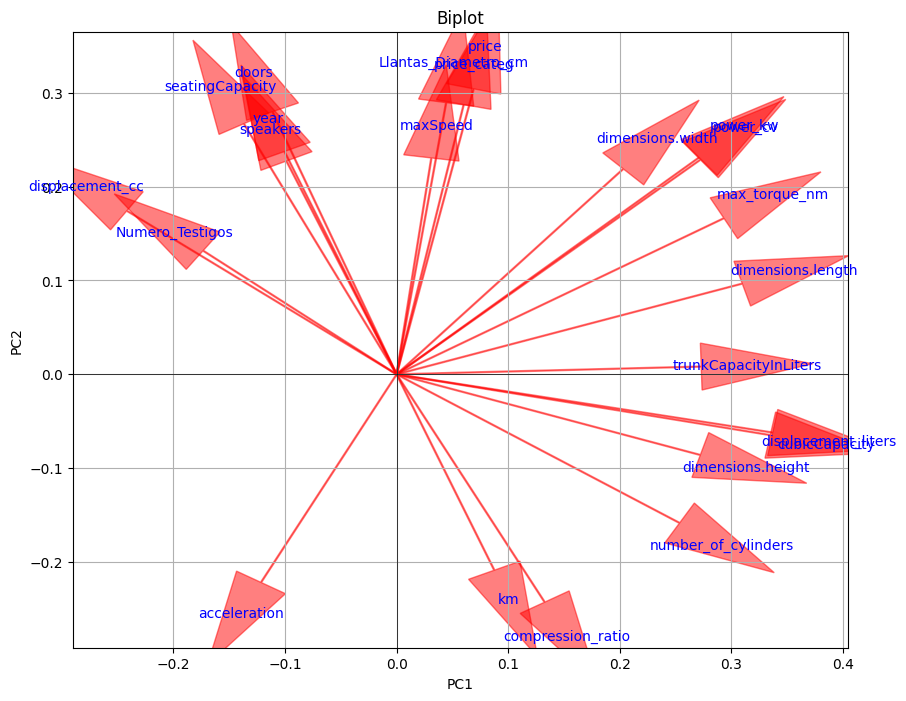

In [13]:
def biplot(score, coeff, labels=None):
    plt.figure(figsize=(10, 8))
    origin = [0, 0]  # Origen de las flechas

    # Dibujar las flechas
    for i in range(len(coeff)):
        plt.arrow(origin[0], origin[1], coeff[i,0], coeff[i,1], color='r', alpha=0.5, head_width=0.05, head_length=0.1)
        if labels is not None:
            plt.text(coeff[i,0]*1.15, coeff[i,1]*1.15, labels[i], color='blue', ha='center', va='center')

    plt.xlabel("PC1")
    plt.ylabel("PC2")
    plt.title("Biplot")
    plt.grid(True)
    plt.axhline(0, color='black',linewidth=0.5)
    plt.axvline(0, color='black',linewidth=0.5)
    plt.xlim(min(coeff[:,0])*1.2, max(coeff[:,0])*1.2)
    plt.ylim(min(coeff[:,1])*1.2, max(coeff[:,1])*1.2)
    plt.show()

# Llamada a la función biplot
biplot(principal_components, np.transpose(pca.components_[0:2, :]), labels=numerical_columns.columns)

## CART regression with only numerical values

- Using only numerical values we can use the SMOTE technique to generate synthetic value data and rebalance our unbalance dataset.

### SMOTE

In [14]:
X = numerical_columns.drop(columns=["price_categ","price"]) # + price_categ
y = numerical_columns["price_categ"]

In [15]:
# Train-Test Split Before Applying SMOTE
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42)

In [16]:
smote = SMOTE(random_state=42)
X_train_resampled, y_train_resampled = smote.fit_resample(X_train, y_train)

c:\Users\marti\Desktop\asignaturas\machineLearning\Cars_Price_Prediction\.venv\Lib\site-packages\joblib\externals\loky\backend\context.py:136: UserWarning: Could not find the number of physical cores for the following reason:
[WinError 2] The system cannot find the file specified
Returning the number of logical cores instead. You can silence this warning by setting LOKY_MAX_CPU_COUNT to the number of cores you want to use.
  warnings.warn(
  File "c:\Users\marti\Desktop\asignaturas\machineLearning\Cars_Price_Prediction\.venv\Lib\site-packages\joblib\externals\loky\backend\context.py", line 257, in _count_physical_cores
    cpu_info = subprocess.run(
               ^^^^^^^^^^^^^^^
  File "C:\Users\marti\AppData\Local\Programs\Python\Python312\Lib\subprocess.py", line 548, in run
    with Popen(*popenargs, **kwargs) as process:
         ^^^^^^^^^^^^^^^^^^^^^^^^^^^
  File "C:\Users\marti\AppData\Local\Programs\Python\Python312\Lib\subprocess.py", line 1026, in __init__
    self._execute_c

Training the CART Model (Decision Tree) on Resampled Data

In [17]:
clf = DecisionTreeClassifier(random_state=42)
clf.fit(X_train_resampled, y_train_resampled)

DecisionTreeClassifier(random_state=42)

In [18]:
y_pred = clf.predict(X_test)

# Cell 7: Evaluate the Model
# Print classification report and confusion matrix
print("Classification Report:\n", classification_report(y_test, y_pred))
print("Confusion Matrix:\n", confusion_matrix(y_test, y_pred))

Classification Report:
               precision    recall  f1-score   support

           1       0.71      0.78      0.74        45
           2       0.83      0.84      0.83        91
           3       0.96      0.90      0.93       115
           4       0.29      0.40      0.33         5
           8       0.33      0.50      0.40         2

    accuracy                           0.84       258
   macro avg       0.62      0.68      0.65       258
weighted avg       0.85      0.84      0.85       258

Confusion Matrix:
 [[ 35  10   0   0   0]
 [ 12  76   3   0   0]
 [  2   6 103   4   0]
 [  0   0   1   2   2]
 [  0   0   0   1   1]]


After analyzing the results obtained with and without the application of SMOTE, it was observed that models trained without SMOTE demonstrated superior performance in terms of accuracy and stability. Although SMOTE is an effective technique for balancing imbalanced datasets by synthesizing new samples, in this specific case, the models without SMOTE outperformed those with it. 

**Therefore future models will be trained without SMOTE from this point forward.**

# Clasification


In [19]:
def eval_classification(y_test, y_pred):
    result = pd.DataFrame({"Real": y_test, "Prediction": y_pred})
    result["diff"] = result["Real"] - result["Prediction"]
    Evaluator.eval_ordinal_classification(diff=abs(result["diff"]))

def classify(X_train, X_test, y_train, y_test , classifier, classifier_name = None) -> None:
    classifier = classifier
    classifier.fit(X_train, y_train)

    # Predicting the test set results
    y_pred = classifier.predict(X_test)
    eval_classification(y_test, y_pred)

    if classifier_name != None:
        return Evaluator.eval_classification(y_pred = y_pred,  y_true=y_test, binary_classification=False, classifier_name=classifier_name)
    return Evaluator.eval_classification(y_pred = y_pred, y_true=y_test, binary_classification=False)



In [20]:
gas_cars = pd.merge(numerical_columns, categorical_columns, left_index=True, right_index=True, how='inner')
numerical_column_names = list(numerical_columns.columns)
categorical_column_names = list(categorical_columns.columns)

target = gas_cars[["price", "price_categ"]]
gas_cars.drop(columns=["price"], inplace=True)

numerical_column_names.remove("price")


encoders_and_scalers = {}
for column in numerical_column_names:
    scaler = StandardScaler()
    gas_cars[[column]] = scaler.fit_transform(gas_cars[[column]])
    encoders_and_scalers[column] = scaler 

gas_cars_encoded = pd.get_dummies(gas_cars, columns=categorical_column_names)

### CART

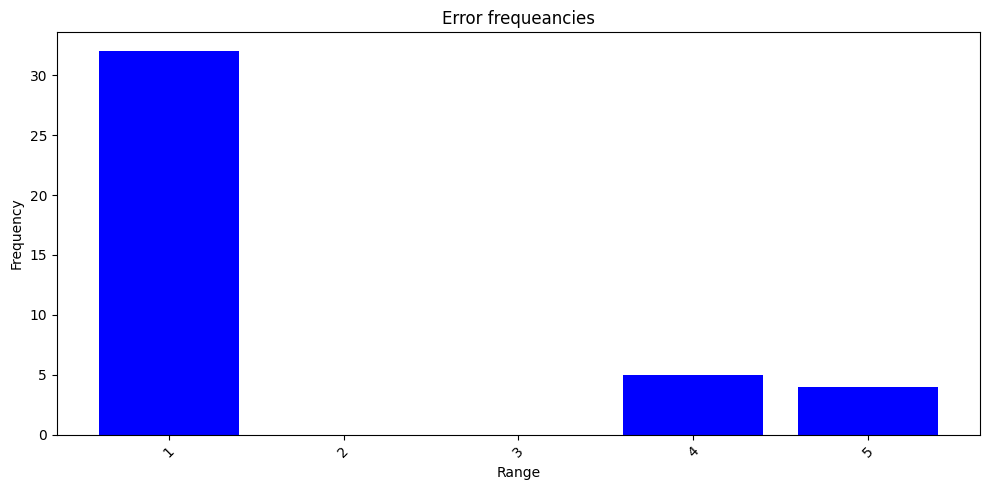

{np.int64(1): np.int64(32), np.int64(4): np.int64(5), np.int64(5): np.int64(4)}
Error mean: 1.7560975609756098
Error rate: 15.891472868217054 %
Overall mean: 0.27906976744186046
Accuracy: 0.8410852713178295 
 Precision: 0.8607956233006353 
 Recall: 0.8410852713178295 
 F1 Score: 0.8494829160700684
Confusion Matrix:
 [[ 37   8   0   0   0]
 [ 11  75   5   0   0]
 [  0   4 104   3   4]
 [  0   0   1   0   4]
 [  0   0   0   1   1]]


In [21]:
classify(X_train, X_test, y_train, y_test, DecisionTreeClassifier(random_state=42), classifier_name="CART")

### Random forest
Random forest can get a better result at a higher computational time cost

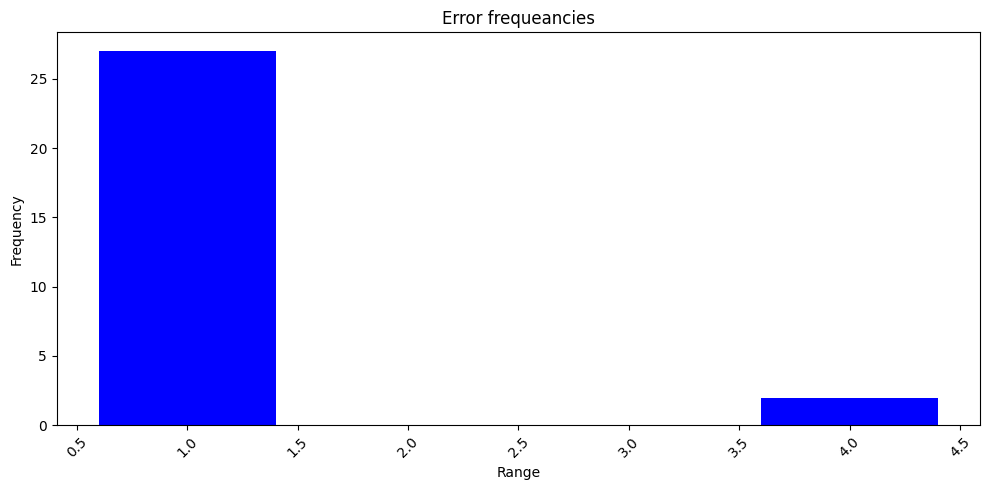

{np.int64(1): np.int64(27), np.int64(4): np.int64(2)}
Error mean: 1.206896551724138
Error rate: 11.24031007751938 %
Overall mean: 0.13565891472868216
Accuracy: 0.8875968992248062 
 Precision: 0.892980418735664 
 Recall: 0.8875968992248062 
 F1 Score: 0.8885300939011497
Confusion Matrix:
 [[ 34  11   0   0   0]
 [  4  83   4   0   0]
 [  0   4 108   3   0]
 [  0   0   1   3   1]
 [  0   0   0   1   1]]


In [22]:
classify(X_train, X_test, y_train, y_test, RandomForestClassifier(random_state=42), classifier_name="RandomForestClassifier")

### SVM
Much higher computational cost, more distributed error, but in overall worse result

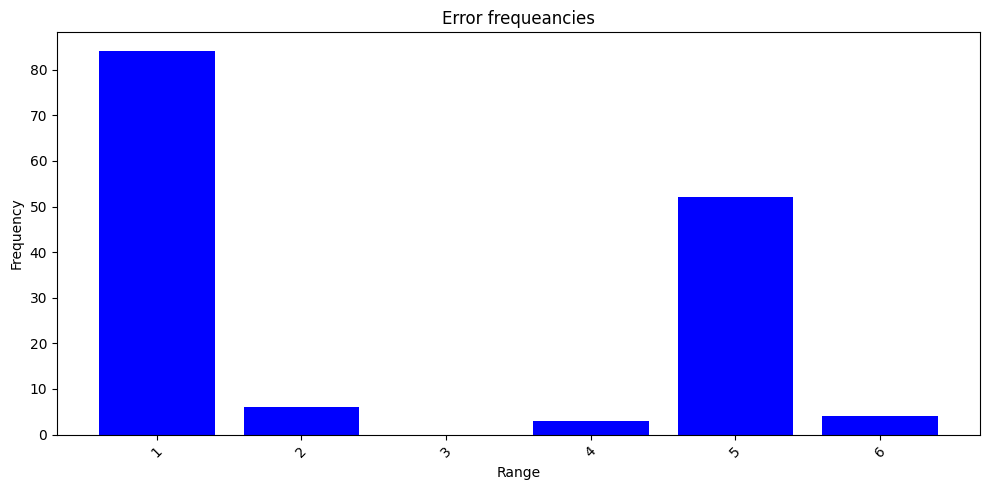

{np.int64(1): np.int64(84), np.int64(2): np.int64(6), np.int64(4): np.int64(3), np.int64(5): np.int64(52), np.int64(6): np.int64(4)}
Error mean: 2.6308724832214767
Error rate: 57.751937984496124 %
Overall mean: 1.5193798449612403
Accuracy: 0.42248062015503873 
 Precision: 0.5908550078294538 
 Recall: 0.42248062015503873 
 F1 Score: 0.44597441275267913
Confusion Matrix:
 [[27 17  1  0  0]
 [26 52  9  0  4]
 [ 3 32 28  0 52]
 [ 0  2  0  0  3]
 [ 0  0  0  0  2]]


c:\Users\marti\Desktop\asignaturas\machineLearning\Cars_Price_Prediction\.venv\Lib\site-packages\sklearn\metrics\_classification.py:1565: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))


In [23]:
classify(X_train_resampled, X_test, y_train_resampled, y_test, SVC(random_state=42), classifier_name="SVC")

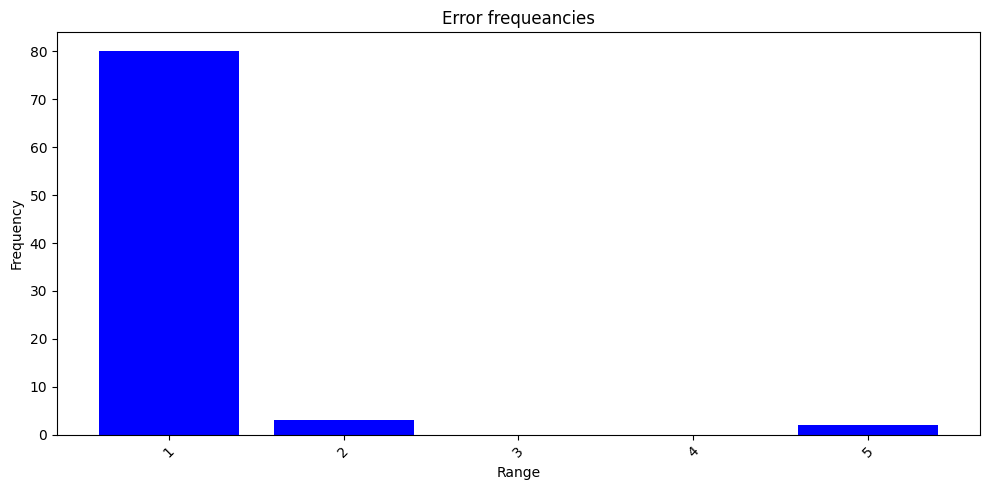

{np.int64(1): np.int64(80), np.int64(2): np.int64(3), np.int64(5): np.int64(2)}
Error mean: 1.1294117647058823
Error rate: 32.945736434108525 %
Overall mean: 0.37209302325581395
Accuracy: 0.6705426356589147 
 Precision: 0.6870694366541542 
 Recall: 0.6705426356589147 
 F1 Score: 0.662936896601902
Confusion Matrix:
 [[21 23  1  0  0]
 [ 7 72 12  0  0]
 [ 0 35 80  0  0]
 [ 0  2  3  0  0]
 [ 0  0  2  0  0]]


c:\Users\marti\Desktop\asignaturas\machineLearning\Cars_Price_Prediction\.venv\Lib\site-packages\sklearn\metrics\_classification.py:1565: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))


In [24]:
classify(X_train, X_test, y_train, y_test, SVC(random_state=42), classifier_name="SVC")

### Naive bayes

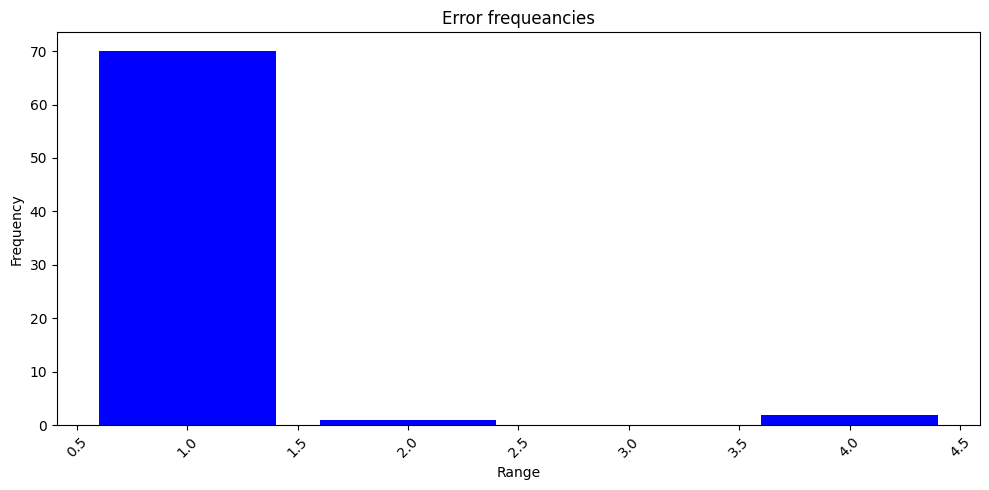

{np.int64(1): np.int64(70), np.int64(2): np.int64(1), np.int64(4): np.int64(2)}
Error mean: 1.095890410958904
Error rate: 28.294573643410853 %
Overall mean: 0.31007751937984496
Accuracy: 0.7170542635658915 
 Precision: 0.7546521382069782 
 Recall: 0.7170542635658915 
 F1 Score: 0.7269944537048775
Confusion Matrix:
 [[38  7  0  0  0]
 [21 59 10  1  0]
 [ 0 22 83 10  0]
 [ 0  0  0  3  2]
 [ 0  0  0  0  2]]


In [25]:
classify(X_train, X_test, y_train, y_test, GaussianNB(), classifier_name="Naive bayes")

### ANN

In [26]:
encoder = OneHotEncoder(sparse_output=False)
y_encoded = encoder.fit_transform(data[['price_categ']])

# Step 2: Split the data
X_train, X_test, y_train, y_test = train_test_split(
    gas_cars_encoded, y_encoded, test_size=0.3, random_state=42
)

# Step 3: Normalize the data
scaler = StandardScaler()
X_train = scaler.fit_transform(X_train)
X_test = scaler.transform(X_test)

# Step 4: Define the ANN model
model = Sequential()
model.add(Dense(128, input_dim=X_train.shape[1], activation='relu'))
model.add(Dense(64, activation='tanh'))
model.add(Dense(32, activation='tanh'))
model.add(Dense(y_train.shape[1], activation='softmax'))  # Softmax for multi-class classification

# Step 5: Compile the model
model.compile(optimizer='adam', loss='categorical_crossentropy', metrics=['accuracy'])

# Step 6: Train the model
history = model.fit(X_train, y_train, validation_data=(X_test, y_test), epochs=100, batch_size=128)

Epoch 1/100


c:\Users\marti\Desktop\asignaturas\machineLearning\Cars_Price_Prediction\.venv\Lib\site-packages\keras\src\layers\core\dense.py:87: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(activity_regularizer=activity_regularizer, **kwargs)


8/8 ━━━━━━━━━━━━━━━━━━━━ 1s 28ms/step - accuracy: 0.5417 - loss: 1.2736 - val_accuracy: 0.7183 - val_loss: 0.7222
Epoch 2/100
8/8 ━━━━━━━━━━━━━━━━━━━━ 0s 12ms/step - accuracy: 0.7927 - loss: 0.5845 - val_accuracy: 0.7855 - val_loss: 0.5657
Epoch 3/100
8/8 ━━━━━━━━━━━━━━━━━━━━ 0s 13ms/step - accuracy: 0.8507 - loss: 0.4373 - val_accuracy: 0.7881 - val_loss: 0.5363
Epoch 4/100
8/8 ━━━━━━━━━━━━━━━━━━━━ 0s 12ms/step - accuracy: 0.8900 - loss: 0.3403 - val_accuracy: 0.8088 - val_loss: 0.5068
Epoch 5/100
8/8 ━━━━━━━━━━━━━━━━━━━━ 0s 11ms/step - accuracy: 0.9117 - loss: 0.2579 - val_accuracy: 0.8010 - val_loss: 0.5073
Epoch 6/100
8/8 ━━━━━━━━━━━━━━━━━━━━ 0s 14ms/step - accuracy: 0.9011 - loss: 0.2466 - val_accuracy: 0.8036 - val_loss: 0.5102
Epoch 7/100
8/8 ━━━━━━━━━━━━━━━━━━━━ 0s 11ms/step - accuracy: 0.9145 - loss: 0.2276 - val_accuracy: 0.7959 - val_loss: 0.5126
Epoch 8/100
8/8 ━━━━━━━━━━━━━━━━━━━━ 0s 12ms/step - accuracy: 0.9254 - loss: 0.2204 - val_accuracy: 0.8062 - val_loss: 0.5115
Epoc

In [27]:
y_pred = model.predict(X_test)
y_pred_classes = np.argmax(y_pred, axis=1)
y_test_classes = np.argmax(y_test, axis=1)

13/13 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step 


In [28]:
Evaluator.eval_classification(y_pred=y_pred_classes, y_true=y_test_classes, binary_classification=False, classifier_name="ANN")

Accuracy: 0.8837209302325582 
 Precision: 0.8953568371453029 
 Recall: 0.8837209302325582 
 F1 Score: 0.8852753929339932
Confusion Matrix:
 [[ 70   3   0   0   0]
 [ 10 121   6   1   0]
 [  0  12 141   8   0]
 [  0   0   1   7   0]
 [  0   0   4   0   3]]


## Regression

In [29]:
X_train, X_test, y_train, y_test = train_test_split(gas_cars_encoded, precios_gas, test_size=0.3, random_state=42)

In [30]:
def regression(X_train, X_test, y_train, y_test , regressor, regressor_name = None) -> None:
    regressor = regressor
    regressor.fit(X_train, y_train)
    # Predicting the test set results
    y_pred = regressor.predict(X_test)

    if regressor_name != None:
        Evaluator.eval_regression(y_pred = y_pred, bins=5, y_true=y_test, plot=False, n_features=X_train.shape[1], regressor_name=regressor_name)
    Evaluator.eval_regression(y_pred = y_pred, y_true=y_test, plot=False)

### Cart

In [31]:
regression(X_train, X_test, y_train, y_test , DecisionTreeRegressor(random_state=42), regressor_name="CART")

MAE: 778.6821705426356 
 MSE: 1756751.4832041343 
 RMSE: 1325.4250198348204 
 R2: 0.9392498322248869 
 MAPE: 5.435493931683752
Mean: 778.6821705426356
Variance: 1150405.5604831441
Standard Deviation: 1072.569606358088
r2_adjusted: 1.0027535890983084
MAE: 778.6821705426356 
 MSE: 1756751.4832041343 
 RMSE: 1325.4250198348204 
 R2: 0.9392498322248869 
 MAPE: 5.435493931683752
Mean: 778.6821705426356
Variance: 1150405.5604831441
Standard Deviation: 1072.569606358088


### Cart Optimized Hyperparameters with Optuna

### Random Forest

In [32]:
regression(X_train, X_test, y_train, y_test , RandomForestRegressor(random_state=42), regressor_name="RandomForest")

MAE: 698.2293453919034 
 MSE: 1191656.5749760407 
 RMSE: 1091.6302372946807 
 R2: 0.9587913614690262 
 MAPE: 4.729197986887422
Mean: 698.2293453919034
Variance: 704132.3562096347
Standard Deviation: 839.1259477632871
r2_adjusted: 1.001867841060704
MAE: 698.2293453919034 
 MSE: 1191656.5749760407 
 RMSE: 1091.6302372946807 
 R2: 0.9587913614690262 
 MAPE: 4.729197986887422
Mean: 698.2293453919034
Variance: 704132.3562096347
Standard Deviation: 839.1259477632871


### SVM Regression

In [33]:
regression(X_train, X_test, y_train, y_test , SVR(kernel='rbf'), regressor_name="SVR")

MAE: 4216.647411894322 
 MSE: 29859873.379807062 
 RMSE: 5464.4188510588265 
 R2: -0.032583341986641035 
 MAPE: 29.52476290334598
Mean: 4216.647411894322
Variance: 12079757.983571967
Standard Deviation: 3475.594623020925
r2_adjusted: 1.0468033313770366
MAE: 4216.647411894322 
 MSE: 29859873.379807062 
 RMSE: 5464.4188510588265 
 R2: -0.032583341986641035 
 MAPE: 29.52476290334598
Mean: 4216.647411894322
Variance: 12079757.983571967
Standard Deviation: 3475.594623020925


### Multivariable regression

In [34]:
linear_regressor = LinearRegression()
linear_regressor.fit(X_train, y_train)

# Predicting the test set results
y_pred = linear_regressor.predict(X_test)

# Optionally, display the coefficients of the model
print("Coefficients:", linear_regressor.coef_)
print("Intercept:", linear_regressor.intercept_)

Coefficients: [-9.72066670e+02  9.40721446e+02 -1.26367561e+06 ...  0.00000000e+00
  0.00000000e+00 -5.16689193e+05]
Intercept: -2663826.9492717073


In [35]:
result = pd.DataFrame({"Real": y_test, "Prediction": y_pred})
result["diff"] = result["Real"].to_numpy() - result["Prediction"].to_numpy()

In [36]:
result

,Real,Prediction,diff
idx,,,
162056,17500,3.186831e+05,-3.011831e+05
39072,14800,1.483133e+04,-3.133034e+01
116181,14990,3.805065e+04,-2.306065e+04
45240,8590,8.043361e+03,5.466390e+02
156962,16900,1.048415e+06,-1.031515e+06
...,...,...,...
63532,11500,1.120786e+04,2.921360e+02
79243,11487,1.189770e+04,-4.106989e+02
37736,33900,4.902806e+04,-1.512806e+04


 ### ANN

In [37]:
# Define the model
model = Sequential()

model.add(Dense(128, input_dim=X_train.shape[1], activation='relu'))
model.add(Dense(64, activation='relu'))
model.add(Dense(32, activation='relu'))
model.add(Dense(16, activation='linear'))
model.add(Dense(1))


c:\Users\marti\Desktop\asignaturas\machineLearning\Cars_Price_Prediction\.venv\Lib\site-packages\keras\src\layers\core\dense.py:87: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(activity_regularizer=activity_regularizer, **kwargs)


In [38]:
model.compile(optimizer='adam', loss='mean_squared_error', metrics=['mae'])

In [39]:
# Train the model
history = model.fit(X_train, y_train, validation_data=(X_test, y_test), epochs=100, batch_size=128)


Epoch 1/100


8/8 ━━━━━━━━━━━━━━━━━━━━ 1s 27ms/step - loss: 245368144.0000 - mae: 14793.8955 - val_loss: 258300384.0000 - val_mae: 15145.4971
Epoch 2/100
8/8 ━━━━━━━━━━━━━━━━━━━━ 0s 12ms/step - loss: 252687296.0000 - mae: 14977.5703 - val_loss: 258095360.0000 - val_mae: 15138.9551
Epoch 3/100
8/8 ━━━━━━━━━━━━━━━━━━━━ 0s 13ms/step - loss: 239327888.0000 - mae: 14617.7959 - val_loss: 257592960.0000 - val_mae: 15122.7891
Epoch 4/100
8/8 ━━━━━━━━━━━━━━━━━━━━ 0s 12ms/step - loss: 250375504.0000 - mae: 14899.6807 - val_loss: 256428784.0000 - val_mae: 15085.3672
Epoch 5/100
8/8 ━━━━━━━━━━━━━━━━━━━━ 0s 12ms/step - loss: 247687968.0000 - mae: 14806.8555 - val_loss: 253942016.0000 - val_mae: 15005.2764
Epoch 6/100
8/8 ━━━━━━━━━━━━━━━━━━━━ 0s 12ms/step - loss: 242915856.0000 - mae: 14683.1523 - val_loss: 248969744.0000 - val_mae: 14844.2568
Epoch 7/100
8/8 ━━━━━━━━━━━━━━━━━━━━ 0s 11ms/step - loss: 236172288.0000 - mae: 14425.3350 - val_loss: 239801712.0000 - val_mae: 14543.3955
Epoch 8/100
8/8 ━━━━━━━━━━━━━━━━

In [40]:
loss, mae = model.evaluate(X_test, y_test, verbose=2)
print(f"Mean Absolute Error on test set: {mae:.2f}")

13/13 - 0s - 3ms/step - loss: 1723014.2500 - mae: 960.4552
Mean Absolute Error on test set: 960.46


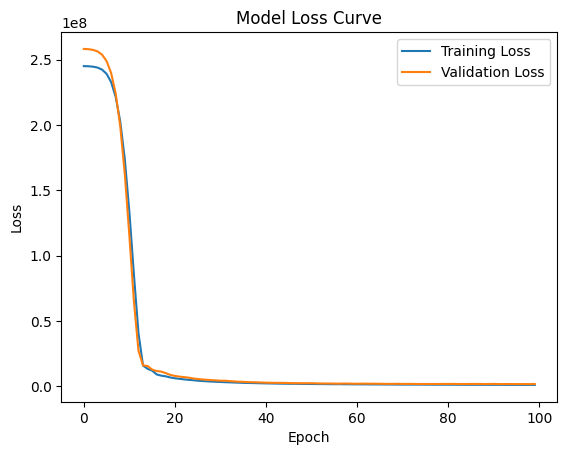

In [41]:
# Plot the loss curve
plt.plot(history.history['loss'], label='Training Loss')
plt.plot(history.history['val_loss'], label='Validation Loss')
plt.xlabel('Epoch')
plt.ylabel('Loss')
plt.legend()
plt.title('Model Loss Curve')
plt.show()

In [42]:
y_pred = model.predict(X_test).flatten()

13/13 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step 


In [43]:
Evaluator.eval_regression(y_pred=y_pred, y_true=y_test, plot=False, n_features=X_train.shape[1], regressor_name="ANN")

MAE: 960.4552001953125 
 MSE: 1723014.19922806 
 RMSE: 1312.6363545278105 
 R2: 0.9404165148735046 
 MAPE: 6.550115900788859
Mean: 960.4551740148579
Variance: 800540.0579361491
Standard Deviation: 894.729041630006
r2_adjusted: 1.0027007075221732


,bin_label,mean,variance,std_dev,max_error,min_error,n_sample
0,"(11180.0, 5590.0]",756.167250,441113.066708,664.163434,2811.281738,4.436523,106
1,"(16770.0, 11180.0]",886.618501,651936.588253,807.425903,3691.640625,7.340820,142
2,"(22360.0, 16770.0]",908.958543,656119.084687,810.011781,4119.296875,37.906250,104


In [44]:
Evaluator.save("gas")

Regression results saved to: evaluation/gas_regression.tex
Classification results saved to: evaluation/gas_classification.tex


# Hyperparameter Tunning

In [45]:
gas_cars_encoded["price_categ"]

idx
143      -0.320203
576      -1.294439
644       0.654032
769       1.628268
787      -0.320203
            ...   
164584   -0.320203
164594   -0.320203
164639   -0.320203
164670   -1.294439
164681   -0.320203
Name: price_categ, Length: 1287, dtype: float64

In [46]:
master = MasterGenerator(X=gas_cars_encoded.drop(columns=["price_categ"]), y_categ=target["price_categ"], y_numeric=precios_gas, n_tries=128, CUML=True, name="HP_gas")

In [108]:
agglomerative_params = {
    "n_clusters": 4,
    "linkage": "single",        # linking criteria: 'ward', 'complete', 'average', 'single'
}


In [109]:
cluster_gen = ClusterGenerator(gas_cars_encoded, use_cuml=False)



result = cluster_gen.custom_clustering("agglomerative", **agglomerative_params)


print("Labels:", result["labels"])
print("Metrics:", result["metrics"])


Labels: [1 1 1 ... 1 1 1]
Metrics: {'silhouette_score': np.float64(0.33538087598809113), 'calinski_harabasz_score': np.float64(80.69462643809172), 'davies_bouldin_score': np.float64(0.6810034985214044)}


In [49]:
master.generate()

[I 2024-12-23 11:30:40,517] A new study created in memory with name: no-name-bae0ac93-84b7-4249-b0a3-ea59bff08757


Optimizing algorithm: cart


[I 2024-12-23 11:30:46,530] Trial 8 finished with value: 30.91531687879485 and parameters: {'max_depth': 15, 'min_samples_split': 3, 'min_samples_leaf': 5, 'max_features': 'log2', 'criterion': 'friedman_mse'}. Best is trial 8 with value: 30.91531687879485.
[I 2024-12-23 11:30:46,717] Trial 10 finished with value: 30.91531687879485 and parameters: {'max_depth': 6, 'min_samples_split': 6, 'min_samples_leaf': 10, 'max_features': 'log2', 'criterion': 'poisson'}. Best is trial 8 with value: 30.91531687879485.
[I 2024-12-23 11:30:46,877] Trial 14 finished with value: 30.91531687879485 and parameters: {'max_depth': 15, 'min_samples_split': 3, 'min_samples_leaf': 3, 'max_features': 'log2', 'criterion': 'poisson'}. Best is trial 8 with value: 30.91531687879485.
[I 2024-12-23 11:30:47,068] Trial 13 finished with value: 8.653210873745138 and parameters: {'max_depth': 9, 'min_samples_split': 17, 'min_samples_leaf': 8, 'max_features': None, 'criterion': 'friedman_mse'}. Best is trial 13 with value:

KeyboardInterrupt: 